# Music Genre Classification

## Overview
This project compares two deep learning models for classifying music genres, utilizing distinct audio feature representations:

1.  **Baseline Model (FNN):** A simple Feedforward Neural Network trained on **MFCCs**.
2.  **Advanced Model (CNN):** A Convolutional Neural Network trained on **Mel-Spectrograms**.

**MFCCs (Mel-Frequency Cepstral Coefficients)** are a condensed way of representing the "shape" of a sound. They focus on how humans perceive pitch, capturing the unique texture or timbre of the audio while discarding less important details.

**Mel-Spectrograms** are visual maps of sound frequencies over time. They provide a much richer, detailed picture of the audio signal, allowing the model to see complex patterns like rhythm and melody that might be lost in the simpler MFCC representation.

---

### Library Imports

All necessary libraries for data processing, model construction, training, and evaluation are imported below.

> **Note:** This project requires **FFmpeg** to be installed on the system for audio conversion and processing. Ensure it is added to your system's PATH before running the notebook.

In [1]:
# System and File Operations
import os
import random
import math

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Audio Processing and Downloading
import yt_dlp
import librosa

# Machine Learning and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Progress Tracking
from tqdm.auto import tqdm

## Part 1: Baseline Model (FNN)
The first phase establishes a performance benchmark using a standard neural network on flattened feature vectors.

### Data Loading & Preprocessing

The data loading process involves importing feature arrays and applying normalization. This standardization step ensures the input features have a mean of zero and a standard deviation of one, preventing features with larger scales from dominating the learning process.

The data is partitioned into approximately 60% for training, 15% for validation, and 25% for testing. The DataLoaders generate batches of 26-dimensional feature vectors paired with their corresponding labels. Input data is normalized to ensure all features are on a similar scale, which allows the model to learn more efficiently and prevents any single feature from dominating the optimization process.

In [2]:
#Function for DataLoaders creation
def create_DataLoaders(train_features_path, train_labels_path, val_features_path, val_labels_path, test_features_path, test_labels_path, batch_size, type):

    # Data loading
    train_X = np.load(train_features_path)
    train_labels = np.load(train_labels_path)
    val_X = np.load(val_features_path)
    val_labels = np.load(val_labels_path)
    test_X = np.load(test_features_path)
    test_labels = np.load(test_labels_path)

    # Mappping of unique labels to integers
    unique_labels = np.unique(train_labels)
    label_to_int = {label: num for num, label in enumerate(unique_labels)}
    int_to_label = {num: label for label, num in label_to_int.items()}

    # Normalization of the data
    mean = np.mean(train_X, axis=0)
    std = np.std(train_X, axis=0)

    mean_val = np.mean(val_X, axis=0)
    std_val = np.std(val_X, axis=0)

    train_X = np.where(std != 0.0, (train_X - mean) / std, train_X - mean)
    val_X = np.where(std_val != 0.0, (val_X - mean_val) / std_val, val_X - mean_val)
    test_X = np.where(std != 0.0, (test_X - mean) / std, test_X - mean)
    

    # Transformation of labels to integers
    train_labels_int = np.array([label_to_int[label] for label in train_labels])
    val_labels_int = np.array([label_to_int[label] for label in val_labels])
    test_labels_int = np.array([label_to_int[label] for label in test_labels])


    # For the input of the CNN in Pytorch a dimension is added, representing the channels
    # Here there is only one channel as each pixel is represented by one value of DB
    if type == "mel":    
        train_X = np.expand_dims(train_X, axis=1)
        val_X = np.expand_dims(val_X, axis=1)
        test_X = np.expand_dims(test_X, axis=1)

    # Convertion of data to Tensors
    train_X_data = torch.tensor(train_X, dtype=torch.float32)
    train_labels_int_data = torch.tensor(train_labels_int, dtype=torch.long)
    val_X_data = torch.tensor(val_X, dtype=torch.float32)
    val_labels_int_data = torch.tensor(val_labels_int, dtype=torch.long)
    test_X_data = torch.tensor(test_X, dtype=torch.float32)
    test_labels_int_data = torch.tensor(test_labels_int, dtype=torch.long)

    # Creation of TensorDatasets
    train_dataset = TensorDataset(train_X_data, train_labels_int_data)
    val_dataset = TensorDataset(val_X_data, val_labels_int_data)
    test_dataset = TensorDataset(test_X_data, test_labels_int_data)

    # Creation of DataLoaders with the given batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #No need to shuffle test data

    return train_loader, val_loader, test_loader, int_to_label, label_to_int


# Definition of paths to the data files
train_features_path_mfcc = './music_genre_data/train/mfccs/X.npy'
train_labels_path_mfcc = './music_genre_data/train/mfccs/labels.npy'
val_features_path_mfcc = './music_genre_data/val/mfccs/X.npy'
val_labels_path_mfcc = './music_genre_data/val/mfccs/labels.npy'
test_features_path_mfcc = './music_genre_data/test/mfccs/X.npy'
test_labels_path_mfcc = './music_genre_data/test/mfccs/labels.npy'

# Creation of DataLoaders
batch_size = 16
train_loader_mfcc, val_loader_mfcc, test_loader_mfcc, int_to_label, _ = create_DataLoaders(train_features_path_mfcc, train_labels_path_mfcc, val_features_path_mfcc, val_labels_path_mfcc,
                                                                              test_features_path_mfcc, test_labels_path_mfcc, batch_size, "mfcc")

# Display the number of batches in each DataLoader
print(f'Train DataLoader: {len(train_loader_mfcc)} batches')
print(f'Validation DataLoader: {len(val_loader_mfcc)} batches')
print(f'Test DataLoader: {len(test_loader_mfcc)} batches\n')

# Display the shape of the data
inputs, labels = next(iter(train_loader_mfcc))
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

# Display the mapping of integers to their respective class names.
print(f"\nClassification Maping: {int_to_label}")

Train DataLoader: 200 batches
Validation DataLoader: 50 batches
Test DataLoader: 86 batches

Inputs shape: torch.Size([16, 26])
Labels shape: torch.Size([16])

Classification Maping: {0: np.str_('blues'), 1: np.str_('classical'), 2: np.str_('hiphop'), 3: np.str_('rock_metal_hardrock')}


### Neural Network Definition
The architecture is a fully connected Feedforward Neural Network (FNN) with two hidden layers. It processes the 26-dimensional MFCC vectors through a series of linear transformations, reducing dimensionality layer-by-layer (128 $\rightarrow$ 32) to extract features before the final classification. An explicit flattening layer is omitted here as the input data is already provided as 1D vectors by the DataLoaders.

In [3]:
# Fully connected neural network with two hidden layers
class FullyConnectedNN(nn.Module):
    
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        #self.flatten = nn.Flatten()  
        self.l1 = nn.Linear(26, 128)
        self.l2 = nn.Linear(128, 32)
        self.l3 = nn.Linear(32, 4)

    def forward(self, input):
        #output = self.flatten(input)
        output = self.l1(input)
        output = self.l2(output)
        output = self.l3(output)
        return output

# Creation of a model instance
model = FullyConnectedNN()

# Display of the model architecture
print(model)

FullyConnectedNN(
  (l1): Linear(in_features=26, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=32, bias=True)
  (l3): Linear(in_features=32, out_features=4, bias=True)
)


### Evaluation Framework
The evaluation process assesses model performance using standard metrics. The `evaluate_network` function calculates the average loss, accuracy, and **F1 score** on a given dataset.

A confusion matrix visualization is implemented to analyze classification errors. This generates a normalized heatmap comparing predicted versus true labels, highlighting which genres are most frequently confused by the model.

In [4]:
# Function for model evaluation
def evaluate_network(model, dataloader, loss_function, device):
    
    # Setting the Pytorch model to evaluation mode
    model.eval()  
    
    total_loss = 0
    all_preds = []
    all_labels = []

    # Disable of gradient computation
    with torch.no_grad():  

        # Iterations over each batch computing the NN output and loss
        for X, y in dataloader:
            
            # Transfer of data to the designated device (CPU or GPU)
            X, y = X.to(device), y.to(device)
            
            # Computation of prediction and loss
            pred = model(X)
            loss = loss_function(pred, y)
            total_loss += loss.item()
            
            # Collection of predictions and labels of each batch
            all_preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    # Metrics Calculation
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Return of the requested metrics
    return avg_loss, f1, accuracy, conf_matrix

In [5]:
# Function for visual representation of the confusion matrix
def display_confusion_matrix(conf_matrix, int_to_label):

    # Normalization of the confusion matrix
    normalized_conf_matrix = conf_matrix / np.sum(conf_matrix) * len(int_to_label)

    # Creation of DataFrame for better visualization
    names = [int_to_label[0], int_to_label[1], int_to_label[2], int_to_label[3]]
    confusion_matrix_dataframe = pd.DataFrame(normalized_conf_matrix, index=names, columns=names)

    # Plotting of the confusion matrix
    fig, ax = plt.subplots(figsize=(9, 9))
    cax = ax.matshow(confusion_matrix_dataframe, cmap='OrRd')   # Setting the desired colormap
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    fig.colorbar(cax, fraction=0.046, pad=0.04)

    # Setting tick marks and labels
    tick_marks = np.arange(len(names))
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.xticks(tick_marks, names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, names, fontsize=12)

    # Annotation and colouring of the confusion matrix cells
    threshold = confusion_matrix_dataframe.max().max() / 2.
    for i, j in np.ndindex(confusion_matrix_dataframe.shape):
        plt.text(j, i, format(confusion_matrix_dataframe.iloc[i, j], '.2f'), horizontalalignment="center",
                color="white" if confusion_matrix_dataframe.iloc[i, j] > threshold else "black")

    # Labeling of the axes
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.show()

In [6]:

# Function to display results of a model evaluation
def display_results(title, loss, f1, accuracy, conf_matrix, int_to_label):
    print(title)
    print("------------------------")
    print(f"Loss: {loss:.4f}")
    print("------------------------")
    print(f"F1 Score: {f1:.4f}")
    print("------------------------")
    print(f"Accuracy: {accuracy:.4f}")
    print("------------------------")
    display_confusion_matrix(conf_matrix, int_to_label)

### Training & Model Selection

A training loop is implemented that monitors the **Validation F1 Score**. Instead of using the model weights from the final epoch, the model state is saved whenever the validation score improves. This strategy ensures the selection of the model version that generalizes best to unseen data, mitigating overfitting by ignoring epochs where validation performance begins to decline.

Saving and loading the `best_model.pt` state ensures that the highest performing weights are accurately preserved and can be reliably restored for inference.

In [7]:
# Function for model training (A scheduler positional attribute has been added with a default value of null for future use)
def train_network_best_score(epochs, optimizer, dataloader, val_dataloader, loss_function, model, device, scheduler=None, model_filename='best_model'):
    
    # Variables for storing the best model state, the highest F1 score, and the epoch at which it was achieved
    best_model_state = None
    best_epoch = 0
    best_f1 = 0

    # Create 'models' directory
    if not os.path.exists('models'):
        os.makedirs('models')

    # Displaying the progress of iterations over the given number of epochs using tqdm for a time progress bar
    for epoch in tqdm(range(epochs), leave=True, position=0, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}], {rate_fmt}{postfix}]'):
        
        # Setting the Pytorch model to training mode
        model.train()
        total_loss = 0

        # Iterations over each batch computing the NN output - loss and performing weight updates
        for (X, y) in dataloader:

            # Transfer of data to the designated device (CPU or GPU)
            X, y = X.to(device), y.to(device)
            # Computation of prediction and loss
            pred = model(X)
            loss = loss_function(pred, y)

            # Backpropagation
            optimizer.zero_grad()        # Resets the gradients of optimized parameters
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Computation of epoch average loss and selective display. 
        avg_loss = total_loss / len(dataloader)       
        if epoch == 0 or (epoch+1) % 5 == 0: print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # In case of nan average loss, training is stopped
        if math.isnan(avg_loss):  
            print(f"Got loss of nan value after epoch {epoch+1}. Training has been stopped. Please try adjusting the learning rate.")
            return None

        # If a scheduler is provided, new learning rates are calculated and selectively displayed
        if scheduler: 
            scheduler.step()
            if epoch == 0 or (epoch+1) % 5 == 0: print(f"Learning Rate after epoch {epoch+1}: {scheduler.get_last_lr()[0]:.5f}")

        # Evaluation of the model at the end of each epoch using the validation dataset and calculation of the F1 score
        _, f1, _, _ = evaluate_network(model, val_dataloader, loss_function, device)

        # Saving the model with the best F1 score
        if f1 > best_f1:

            # Deep copy the best model weights and save them to disk
            best_model_state = model.state_dict().copy() 

            # Save to the 'models' folder
            save_path = os.path.join('models', model_filename + '.pt')
            torch.save(best_model_state, save_path)

    # Loading the best model state so as to return it
    if best_model_state:
        load_path = os.path.join('models', model_filename + '.pt')
        model.load_state_dict(torch.load(load_path))
        print(f"\nLoaded best model from {load_path}")

    # Display of the epoch number the best model was achieved
    print(f"\nBest Model after Epoch {best_epoch+1}/{epochs} with F1 Score: {best_f1:.4f}\n")
    # Return the model that achieved the highest F1 Score on the validation set
    return model

### Training Execution

The model training is executed on the **CPU**. Given the small parameter size of this network, the overhead of transferring data batches to a GPU would outweigh the parallel processing benefits, making the CPU a more efficient choice for this specific baseline.

  0%|                                                     | 0/30 [00:00], ?it/s]

Epoch 1/30, Loss: 1.2867
Epoch 5/30, Loss: 0.9322
Epoch 10/30, Loss: 0.8268
Epoch 15/30, Loss: 0.7821
Epoch 20/30, Loss: 0.7598
Epoch 25/30, Loss: 0.7478
Epoch 30/30, Loss: 0.7408

Loaded best model from models\FFN_best_model.pt

Best Model after Epoch 1/30 with F1 Score: 0.0000


Metrics for Test Set
------------------------
Loss: 0.7985
------------------------
F1 Score: 0.6805
------------------------
Accuracy: 0.6860
------------------------


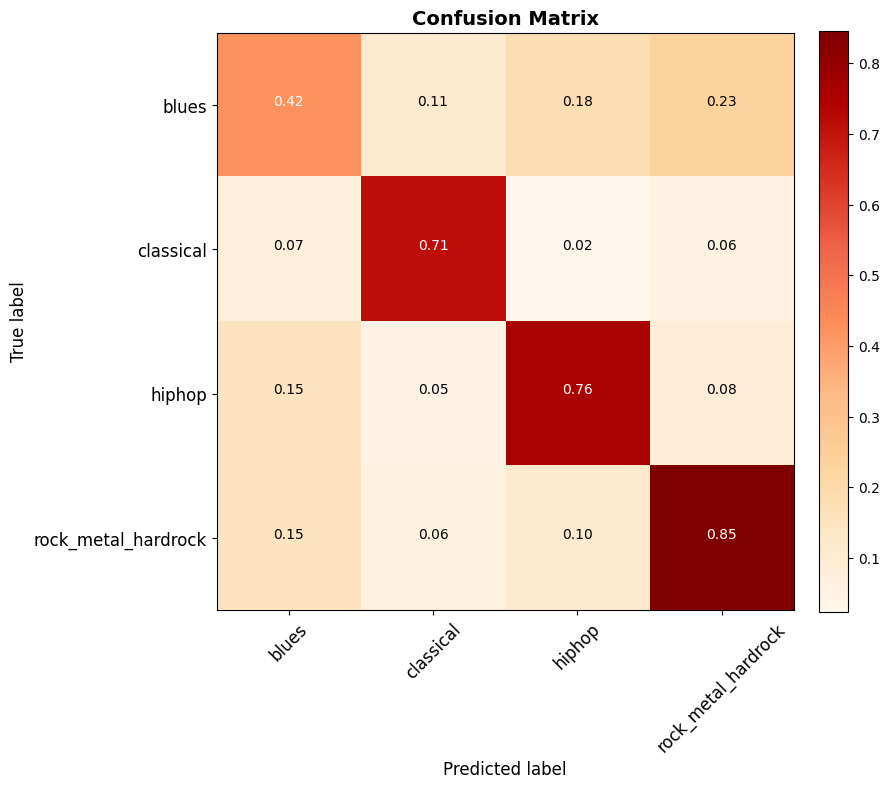

In [8]:
# Setup device as cpu, better than gpu in this case
device = 'cpu'

# Creation of the model instance
model = FullyConnectedNN().to(device)

# Definition of the optimizer, loss function, and number of epochs
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()
epochs = 30

# Training of the model and saving the best model based on validation F1 score
ffn_model = train_network_best_score(epochs, optimizer, train_loader_mfcc, val_loader_mfcc, loss_function, model, device, model_filename='FFN_best_model')

# Evaluation of the best model on the test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_network(ffn_model, test_loader_mfcc, loss_function, device)

# Display of the performance metrics
display_results("\nMetrics for Test Set", test_loss, test_f1, test_accuracy, test_conf_matrix, int_to_label)

## Part 2: Advanced Model (CNN)
The second phase involves training a Convolutional Neural Network (CNN) on **Mel-Spectrograms**. Unlike the 1D MFCC vectors used in the baseline, Mel-Spectrograms are 2D visual representations of audio frequencies over time, allowing the model to learn spatial patterns similar to image classification.

### Data Loading & Preprocessing
The data loading process is similar to the MFCC approach but handles 2D image data. The `create_DataLoaders` function is called with the `"mel"` flag, which adds a **channel dimension** to the tensors (reshaping them to `[Batch_Size, 1, 128, 21]`). This step is crucial for PyTorch's `Conv2d` layers, which require inputs in the format `(Batch, Channel, Height, Width)`.

The dataset follows the same partition strategy (Training, Validation, Testing) used in the baseline model.

In [9]:
# Definition of paths to the data files
train_features_path_mel = './music_genre_data/train/melgrams/X.npy'
train_labels_path_mel = './music_genre_data/train/melgrams/labels.npy'
val_features_path_mel = './music_genre_data/val/melgrams/X.npy'
val_labels_path_mel = './music_genre_data/val/melgrams/labels.npy'
test_features_path_mel = './music_genre_data/test/melgrams/X.npy'
test_labels_path_mel = './music_genre_data/test/melgrams/labels.npy'

# Creation of DataLoaders
batch_size = 16
train_loader_mel, val_loader_mel, test_loader_mel, int_to_label, label_to_int = create_DataLoaders(train_features_path_mel, train_labels_path_mel, val_features_path_mel, val_labels_path_mel,
                                                                                      test_features_path_mel, test_labels_path_mel, batch_size, "mel")

# Display the number of batches in each DataLoader
print(f'Train DataLoader: {len(train_loader_mel)} batches')
print(f'Validation DataLoader: {len(val_loader_mel)} batches')
print(f'Test DataLoader: {len(test_loader_mel)} batches\n')

# Display the shape of the data
inputs, labels = next(iter(train_loader_mel))
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

# Display the mapping of integers to their respective class names.
print(f"\nClassification Maping: {int_to_label}")

Train DataLoader: 200 batches
Validation DataLoader: 50 batches
Test DataLoader: 86 batches

Inputs shape: torch.Size([16, 1, 21, 128])
Labels shape: torch.Size([16])

Classification Maping: {0: np.str_('blues'), 1: np.str_('classical'), 2: np.str_('hiphop'), 3: np.str_('rock_metal_hardrock')}


### Data Visualization
To better understand the input features, `plot_spectrograms` visualizes a random Mel-Spectrogram for each of the four target genres.

The spectrograms are transposed during plotting to ensure that **Time** is represented on the horizontal axis and **Frequency** on the vertical axis. Visualizing these inputs helps confirm that the data is correctly processed and allows for the observation of distinct textural differences between genres that the CNN will learn to recognize.

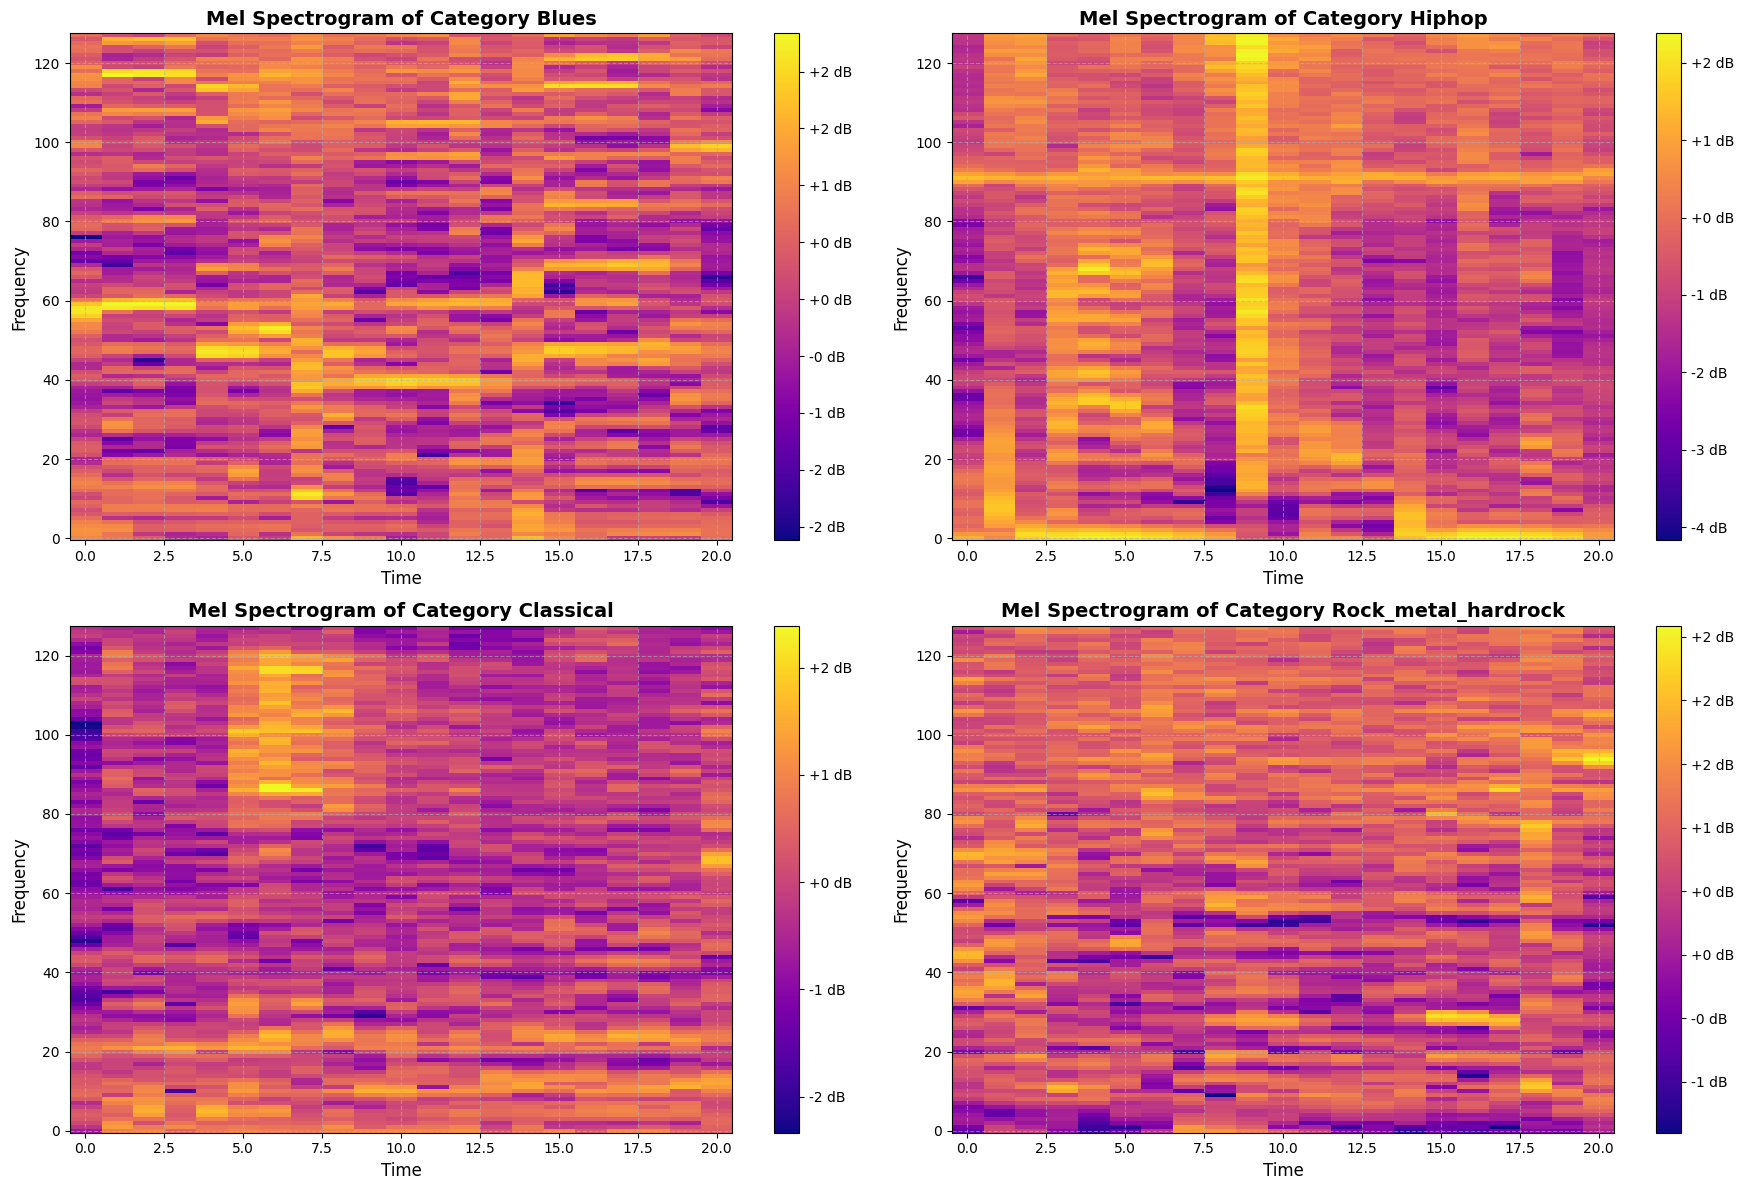

In [10]:
# Function to plot random spectrograms for each class
def plot_spectrograms(dataloader, target_labels, int_to_label):

    # Set that keeps track of found labels
    found_labels = set()

    # Create a figure with subplots arranged in a 2 by 2 grid to display the spectrograms.
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    # Iterate through the DataLoader
    for inputs, labels in dataloader:
        for input, label in zip(inputs, labels):
            
            # Check if the label is in target labels and has not been found yet
            if label.item() in target_labels and label.item() not in found_labels:

                found_labels.add(label.item())

                # Plot the spectrogram for the current input
                ax = axes[len(found_labels) - 1]  # Select the subplot axis
                im = ax.imshow(input.squeeze(0).T, aspect='auto', origin='lower', cmap='plasma')  # Display the spectrogram with the desired colormap 
                ax.set_title("Mel Spectrogram of Category " + int_to_label[label.item()].capitalize(), fontsize=14, fontweight='bold')  
                ax.set_xlabel("Time", fontsize=12)
                ax.set_ylabel("Frequency", fontsize=12)  
                ax.grid(True, linestyle='--', alpha=0.6)  # Add grid lines to the plot

                # Add colorbar
                fig.colorbar(im, ax=ax, format='%+2.0f dB')

            # Check if all the target labels were found
            if found_labels == target_labels:

                plt.tight_layout()  
                plt.show()  
                return  

    
# Target labels to look for
target_labels = {0, 1, 2, 3}

# Diplay of the spectrograms
plot_spectrograms(train_loader_mel, target_labels, int_to_label)

### Genre Characteristics Analysis

Distinct variations in frequency range, harmonic content, and temporal patterns (tempo) are observable across the different genres. The CNN aims to extract these spatial patterns to classify unseen audio samples effectively.

Below are the general characteristics expected in the spectrograms for each genre:

* **Blues**
    * **Frequency:** Moderate to low frequencies.
    * **Patterns:** Smooth, flowing transitions with noticeable harmonic content.
    * **Tempo:** Moderate, reflecting a soulful and expressive nature.

* **Classical**
    * **Frequency:** Wide dynamic range, spanning from very low to very high frequencies.
    * **Patterns:** Complex, layered structures with varying intensities; clear separation between instrumental sections.
    * **Tempo:** Highly variable depending on the piece, often featuring dynamic shifts.

* **Rock/Metal**
    * **Frequency:** Broad range, with strong emphasis on mid-to-high frequencies.
    * **Patterns:** Dense, high-energy regions with rapid changes; strong presence of rhythmic patterns and distortion.
    * **Tempo:** Fast and aggressive.

* **Hip Hop**
    * **Frequency:** Strong emphasis on low-to-mid frequencies (bass & vocals).
    * **Patterns:** Repetitive, rhythmic beats with strong bass lines; distinct percussive elements.
    * **Tempo:** Moderate to fast, driven by a steady groove and lyrical flow.

### Neural Network Definition
The architecture is a Convolutional Neural Network (CNN) designed to process 2D Mel-Spectrograms. To maintain spatial dimensions during feature extraction and effectively reduce dimensionality, we employ **Zero Padding** and **Max Pooling**.

* **Convolutional Layers:** Use $5 \times 5$ kernels with `padding='same'` (equivalent to `padding=2` for this kernel size) to preserve input dimensions (`21x128`) after convolution.
* **Max Pooling:** Uses $2 \times 2$ windows with a stride of 2. This effectively halves the spatial dimensions at each step, compressing the feature map while retaining prominent features.
* **Fully Connected Layers:** The final feature map is flattened and passed through dense layers for classification.

In [11]:
# Convolutional Neural Network with Padding and Pooling
class CNN_Padding_Pooling(nn.Module):
  
  def __init__(self):
    super().__init__()
    # Define the convolutional layers
    self.conv1 = nn.Conv2d(1, 16, 5, padding = 'same')
    self.conv2 = nn.Conv2d(16, 32, 5, padding = 'same')
    self.conv3 = nn.Conv2d(32, 64, 5, padding = 'same')
    self.conv4 = nn.Conv2d(64, 128, 5, padding = 'same')
    self.pool = nn.MaxPool2d(2, 2)
    
    # Define the fully connected layers
    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256 )
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, image):
    # Forward pass through convolutional layers
    output = self.pool(self.conv1(image))        
    output = self.pool(self.conv2(output))       
    output = self.pool(self.conv3(output))                
    output = self.pool(self.conv4(output))
                
    # Flatten the output from the convolutional layers
    input_image_vector = output.view(output.size(0), -1)

    # Forward pass through fully connected layers
    output = self.dense1(input_image_vector)
    output = self.dense2(output)
    output = self.dense3(output)
    output = self.dense4(output)

    return output 
  
# Create the model instance
model_padding_pooling = CNN_Padding_Pooling()

# Print the model architecture
print(model_padding_pooling)

CNN_Padding_Pooling(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)


#### &nbsp;&nbsp;<ins>Dimension Calculation</ins>
&nbsp;&nbsp;After applying padding and pooling to the Convolutional Layers, we need to recalculate the dimensions of the input vector for the first fully connected layer.

- For padding, the following formula will be used:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Dimension_{\text{out}} = \left\lfloor \frac{Dimension_{\text{in}} - Kernel\_Size + 2Padding\_Size}{Stride} \right\rfloor + 1$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We observe that for the given kernel size of 5 and padding of two elements, the formula becomes:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Dimension_{\text{out}} = \left\lfloor \frac{Dimension_{\text{in}} - 5 + 2\cdot2}{1} \right\rfloor + 1 = \left\lfloor \frac{Dimension_{\text{in}} - 1}{1} \right\rfloor + 1 = Dimension_{\text{in}} - 1 + 1 = Dimension_{\text{in}}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We observe that the dimensions remain unchanged by the padding operation, therefore the 'same' value is used for the padding attribute.

- For the pooling operation with a kernel size of two, which means both the kernel size and stride are two, the following formula will be used:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Dimension_{\text{out}} = \left\lfloor \frac{Dimension_{\text{in}} - Kernel\_Size}{Stride} \right\rfloor + 1$

- For input image vectors with dimensions of 21x128, applying the formula results in:

&nbsp;&nbsp;&nbsp;&nbsp;**Pooling Layer One**

- $\left\lfloor \frac{21 - 2}{2} \right\rfloor + 1 = \left\lfloor 9.5 \right\rfloor + 1 = 9 + 1 = 10$

- $\left\lfloor \frac{128 -2}{2} \right\rfloor + 1 = \left\lfloor 63\right\rfloor + 1 = 64$

&nbsp;&nbsp;&nbsp;&nbsp;**Pooling Layer Two**

- $\left\lfloor \frac{10 -2}{2} \right\rfloor + 1 = \left\lfloor 4 \right\rfloor + 1 = 5$

- $\left\lfloor \frac{64 -2}{2} \right\rfloor + 1 = \left\lfloor 31\right\rfloor + 1 = 32$

&nbsp;&nbsp;&nbsp;&nbsp;**Pooling Layer Three**

- $\left\lfloor \frac{5 - 2}{2} \right\rfloor + 1 = \left\lfloor 1.5 \right\rfloor + 1 = 1 + 1 = 2$

- $\left\lfloor \frac{32 -2}{2} \right\rfloor + 1 = \left\lfloor 15\right\rfloor + 1 = 16$

&nbsp;&nbsp;&nbsp;&nbsp;**Pooling Layer Four**

- $\left\lfloor \frac{2 -2}{2} \right\rfloor + 1 = \left\lfloor 0 \right\rfloor + 1 = 1$

- $\left\lfloor \frac{16 -2}{2} \right\rfloor + 1 = \left\lfloor 7\right\rfloor + 1 = 8$

The output vectors of the fourth Pooling Layer have dimensions of 1x8, and this layer generates 128 different outputs. Consequently, the final vector to be flattened will be a single vector of size 1x8x128 = 1024. This flattened vector will be the new input size for the first fully connected layer of the CNN model. 


### Reproducibility

To ensure that the experimental results are consistent and can be replicated, we explicitly set the random seeds for all libraries involving stochastic processes (Python, NumPy, and PyTorch).

The code below configures the environment for deterministic execution:
* **Seeds:** Fixed seeds are set for CPU, GPU, and NumPy generators.
* **CuDNN Configuration:** The CUDA Deep Neural Network library (CuDNN) is forced to use deterministic algorithms (`deterministic = True`) and disable auto-tuning (`benchmark = False`). This prevents the GPU from selecting different algorithms based on hardware state, which can introduce slight variations in results.
* **Environment:** The `PYTHONHASHSEED` is fixed to ensure consistent hash-based operations.

*References: [Pytorch Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html) and [How to Reproduce Pytorch Code](https://faizanansari541.medium.com/how-to-reproduce-c143e807caa5).*

In [12]:
# Seeds definition
def set_seed(seed):
    
    # Sets the seed for generating random numbers in PyTorch on the CPU.
    torch.manual_seed(seed)

    # Sets the seed for generating random numbers on the current GPU.
    torch.cuda.manual_seed(seed)

    # Sets the seed for generating random numbers on all GPUs.
    torch.cuda.manual_seed_all(seed)

    # Sets the seed for NumPy's random number generator.
    np.random.seed(seed)

    # Sets the seed for Python's built-in random module.
    random.seed(seed)

    # Ensures that the CuDNN library uses deterministic algorithms only.
    # This guarantees that operations like convolution produce the same results every time.
    torch.backends.cudnn.deterministic = True

    # Disables CuDNN auto-tuning that selects the best algorithm based on the input size and hardware.
    # Ensures that the same algorithm is used every time, which helps in achieving reproducibility.
    torch.backends.cudnn.benchmark = False

    # Sets the PYTHONHASHSEED environment variable to ensure reproducibility for hash-based operations.
    os.environ["PYTHONHASHSEED"] = str(seed)

### Hyperparameter Optimization

To enhance the CNN's performance, a series of experiments were conducted to identify the optimal configuration. The model architecture remained constant while different Optimizers, Activation Functions, and Learning Rate Schedulers were tested to find the best combination for this specific dataset.

#### 1. Optimizer Selection
Various algorithms were tested to determine which converges fastest and yields the highest stability.

| Index | Optimizer | Accuracy | F1 Score | Best Epoch | Time (s) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | SGD | 0.7413 | 0.7450 | 27 | 41.93 |
| 2 | ASGD | 0.7275 | 0.7284 | 27 | 59.33 |
| 3 | Adagrad | **0.7551** | **0.7510** | 9 | 46.89 |
| 4 | RMSprop | 0.7500 | 0.7503 | 27 | 46.41 |
| 5 | Rprop | 0.7028 | 0.7034 | 29 | 54.77 |
| 6 | Adam | 0.7362 | 0.7384 | 14 | 46.92 |
| 7 | **Adamax** | **0.7413** | **0.7441** | **10** | **46.01** |
| 8 | RAdam | 0.7224 | 0.7271 | 1 | 48.79 |

#### &nbsp;&nbsp;<ins>Comments : </ins>
&nbsp;&nbsp;**Adagrad** and **Adamax** yielded the highest metrics. While Adagrad performed slightly better, its tendency to accumulate squared gradients can stop learning prematurely. **Adamax**, being stable and handling sparse updates well (common in spectrograms), was selected for the final model to ensure robustness.

---

#### 2. Activation Function Selection
Non-linearity was introduced using various activation functions to observe their impact on feature extraction.

| Index | Activation | Accuracy | F1 Score | Best Epoch | Time (s) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | **ReLU** | **0.7427** | **0.7449** | **17** | **195.13** |
| 2 | LeakyReLU | 0.7456 | 0.7503 | 15 | 192.37 |
| 3 | PReLU | 0.7544 | 0.7567 | 21 | 202.54 |
| 4 | RReLU | 0.7594 | 0.7627 | 25 | 195.25 |
| 5 | ELU | 0.7609 | 0.7626 | 28 | 194.09 |
| 6 | CELU | 0.7609 | 0.7626 | 28 | 193.46 |
| 7 | Softplus | 0.7188 | 0.7111 | 10 | 193.21 |
| 8 | Hardtanh | 0.7507 | 0.7566 | 5 | 193.95 |
| 9 | LogSigmoid | 0.6686 | 0.6638 | 8 | 191.73 |
| 10 | LogSoftmax | 0.6911 | 0.6864 | 26 | 202.49 |

#### &nbsp;&nbsp;<ins>Comments : </ins>
&nbsp;&nbsp;While variants like **ELU** and **PReLU** offered marginal improvements, they come with increased computational complexity. **ReLU** remains the standard for CNNs due to its efficiency and sparsity (setting negative values to zero). To prioritize generalization and simplicity for the final architecture, **ReLU** is used.

---

#### 3. Learning Rate Scheduler Selection
Schedulers adjust the learning rate during training to escape local minima and settle into the global minimum.

| Index | Scheduler | Accuracy | F1 Score | Best Epoch | Time (s) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | ConstantLR | 0.7507 | 0.7522 | 19 | 195.05 |
| 2 | ExponentialLR | 0.7522 | 0.7557 | 28 | 189.79 |
| 3 | **StepLR** | **0.7551** | **0.7578** | **19** | **189.72** |
| 4 | MultiStepLR | 0.7551 | 0.7578 | 19 | 189.26 |
| 5 | PolynomialLR | 0.7427 | 0.7481 | 15 | 186.14 |
| 6 | CosineAnnealing | 0.7478 | 0.7497 | 20 | 189.46 |
| 7 | CyclicLR | 0.7355 | 0.7398 | 22 | 191.06 |
| 8 | LambdaLR | 0.7515 | 0.7531 | 18 | 195.35 |
| 9 | LinearLR | 0.7500 | 0.7535 | 7 | 193.07 |
| 10 | Chained | 0.7522 | 0.7560 | 8 | 191.28 |

#### &nbsp;&nbsp;<ins>Comments : </ins>
&nbsp;&nbsp;**StepLR** proved to be the most effective, offering the highest F1 Score (0.7578) with reasonable training time. Its aggressive decay at specific intervals helps the model settle into finer regions of the loss landscape effectively.

### Final Model Configuration & Regularization Strategy

Based on the comparative analysis and hyperparameter tuning, the **Final Convolutional Neural Network** is defined. This architecture inherits the base structure (Convolutional and Pooling layers) while integrating several key regularization techniques to enhance performance and generalization:

* **Batch Normalization:** Stabilizes the training process and improves convergence by reducing internal covariate shift. It normalizes inputs for each mini-batch, introducing a slight noise that functions as a form of regularization, making the model less sensitive to individual neuron weights.

* **Dropout:** Enhances model robustness by randomly setting a portion of input units to zero during training (typically with a probability of 0.5). This prevents neurons from co-adapting too closely, reducing the risk of overfitting and ensuring the model generalizes better to unseen data.

* **Weight Decay (L2 Regularization):** Improves performance by penalizing large weights during training. This encourages the model to learn simpler patterns, further mitigating overfitting.

In [13]:
# Final Optimized CNN with Batch Normalization and Dropout
# Inherits from the base CNN_Padding_Pooling class
class CNN_Batch_Norm_Dropout(CNN_Padding_Pooling):
    
    def __init__(self, activation_function, dropout_prob=0.5):
        # Initialize the parent class (CNN_Padding_Pooling) to get conv/pool/dense layers
        super().__init__()
        
        # --- Define Additional Layers (Specific to this optimized model) ---
        
        # Batch Normalization Layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Activation Function (e.g., ReLU, PReLU)
        self.activation_function = activation_function

    def forward(self, image):
        # Forward pass: Conv -> BN -> Activation -> Pool
        # We access the conv/pool layers from the parent class (self.conv1, self.pool, etc.)
        output = self.pool(self.activation_function(self.bn1(self.conv1(image))))
        output = self.pool(self.activation_function(self.bn2(self.conv2(output))))
        output = self.pool(self.activation_function(self.bn3(self.conv3(output))))
        output = self.pool(self.activation_function(self.bn4(self.conv4(output))))

        # Flatten
        input_image_vector = output.view(output.size(0), -1)

        # Forward pass: Dropout -> Dense -> Activation
        # We access the dense layers from the parent class (self.dense1, etc.)
        output = self.dropout(input_image_vector)
        output = self.activation_function(self.dense1(output))
        
        output = self.dropout(output)
        output = self.activation_function(self.dense2(output))
        
        output = self.dropout(output)
        output = self.activation_function(self.dense3(output))
        
        output = self.dropout(output)
        output = self.dense4(output)

        return output

# Creation of the model instance (Example using PReLU)
model_batch_norm_dropout = CNN_Batch_Norm_Dropout(nn.PReLU())

# Display of the model architecture
print(model_batch_norm_dropout)

CNN_Batch_Norm_Dropout(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

### Model Inference

To evaluate the model's performance on unseen data, an inference function is defined. This function switches the model to evaluation mode, disables gradient calculation for efficiency, and aggregates predictions across batches to compute the final accuracy.

In [14]:
# Function for model inference
def infer(dataloader, model):

    # Setting the Pytorch model to evaluation mode
    model.eval()

    # Initialization of predictions and labels holders
    predictions = []
    labels = []
    
    # No gradient calculations needed during inference
    with torch.inference_mode():
    #with torch.no_grad():

        # Iterations over each batch computing the CNN output
        for X, y in dataloader:
            
            # Transfer of data to the designated device (CPU or GPU)
            X, y = X.to(next(model.parameters()).device), y.to(next(model.parameters()).device)
            
            # Computation of prediction
            pred = model(X)

            # Collection of predictions and labels of each batch
            predictions.extend(torch.argmax(pred, dim=1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    
    # Calculation of metrics
    accuracy = accuracy_score(labels, predictions)
 
    # Return of predictions and accuracy
    return predictions, accuracy

### Data Acquisition & Preprocessing

To evaluate the model on real-world data, a pipeline is implemented to download audio directly from YouTube, convert it to `.wav` format, and slice it into Mel-Spectrogram segments compatible with the trained model.

In [15]:
# Duration of the window for the FFT
window_length = (50 * 1e-3)
# Duration of the hop (stride) between windows for the FFT
hop_length = (50 * 1e-3)
# The size of the mel time dimension
mel_time_size = 22

# Define a "Quiet Logger" to filter out warnings
class QuietLogger:
    debug = warning = lambda *args: None
    def error(self, msg): print(f"ERROR: {msg}")

# Downloads the YouTube video as an audio file and converts it to .wav format
def download_youtube(youtube_url, output_path="output.wav"):
    # yt-dlp options to download best audio and convert to wav
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': 'temp_download',  # Temporary filename
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
        }],
        'quiet': True,
        'overwrites': True,
        'logger': QuietLogger()
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])
            
        # yt-dlp appends the extension, so we rename it to the desired output_path
        if os.path.exists('temp_download.wav'):
            if os.path.exists(output_path):
                os.remove(output_path)
            os.rename('temp_download.wav', output_path)
            
    except Exception as e:
        print(f"Error downloading {youtube_url}: {e}")
        # Clean up temp file if it failed halfway
        if os.path.exists('temp_download.wav'):
            os.remove('temp_download.wav')

# Loads a .wav file and returns the audio signal and sampling rate
def load_wav(filename):

    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs

# Computes the mel spectrogram from an audio signal
def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    
    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out

# Extracts mel spectrograms from an audio file
def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments

# Downloads a YouTube video, extracts mel spectrograms, and saves them as a .npy file
def youtube_to_melgram(url, title, save_dir="npy_data"):
# Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    download_youtube(url)
    if os.path.exists("output.wav"):
        # Process
        melgrams = get_melgrams("output.wav")
        
        # Save
        np.save(os.path.join(save_dir, f"{title}.npy"), melgrams)
        
        # DELETE the wav file
        os.remove("output.wav")

### Prediction Pipeline & Visualization

To classify the processed audio, a pipeline is implemented to convert the saved `.npy` files into PyTorch DataLoaders and visualize the results.

* **Normalization:** To ensure consistency with the training phase, the input data undergoes Z-score normalization using the mean and standard deviation of the input file. A small epsilon ($1e^{-10}$) is added to the standard deviation to prevent division-by-zero errors in silent or uniform audio segments.
* **Tensor Conversion:** The data is formatted into the `(Batch, Channel, Height, Width)` structure required by the CNN.
* **Visualization:** Following inference, a visualization function maps the predicted class for every time segment, allowing for an assessment of classification stability across the duration of the audio track.

In [16]:
# Function for Dataloaders Creation for the saved .npy audio files
def create_DataLoader(file_path, label_to_int, label_name, batch_size):

    # Data loading
    input_file = np.load(file_path)

    # Creation of labels dimension
    generated_labels = np.full(input_file.shape[0], label_to_int[label_name])

    # Normalization of input data
    mean = np.mean(input_file, axis=0)
    std = np.std(input_file, axis=0)

    # Definition of a small epsilon value to prevent division by zero
    epsilon = 1e-10

    # Addition of epsilon to std to avoid division by zero
    safe_std = std + epsilon

    input_file = (input_file - mean) / safe_std
    
    # Addition of channel dimension for CNN
    input_file  = np.expand_dims(input_file , axis=1)

    # Convertion of data to Tensors
    input_data = torch.tensor(input_file, dtype=torch.float32)
    label_data = torch.tensor(generated_labels, dtype=torch.long)

    # Creation of TensorDatasets
    input_dataset = TensorDataset(input_data, label_data)

    # Creation of Dataloader with desired batch size and no shuffle
    input_loader = DataLoader(input_dataset, batch_size=batch_size, shuffle=False)

    # Return of the Ddataloader
    return input_loader

# Function to visualize predictions
def show_predictions(predictions, accuracy, title, int_to_label, label_to_int):

    # Convertion of predicted labels to their corresponding indices
    prediction_indices = [label_to_int[pred] for pred in predictions]
    
    # Creation of timestamps based on the length of predictions
    timestamps = np.arange(len(prediction_indices))

    plt.figure(figsize=(12, 6))
    # Scatter plot of predictions
    plt.scatter(timestamps, prediction_indices, c='blue', label='Predictions', marker='o', s=10)
    plt.xlabel('Timestamps (seconds)')
    plt.ylabel('Music Classes')
    plt.title(f'Music Class Predictions for {title}', fontweight='bold')
    plt.legend()

    # Display of the class labels
    plt.yticks(ticks=np.arange(len(int_to_label)), labels=[int_to_label[i] for i in range(len(int_to_label))])

    # Display of prediction's accuracy
    plt.text(0.35, -0.15, f'Accuracy of prediction: {accuracy:.2f}', transform=plt.gca().transAxes, fontweight='bold', fontsize=12)
    plt.show()


# Function to predict the genre of a YouTube video and display the results
def predict_genre(youtube_path, title, genre, model, save_dir="npy_data"):

    youtube_to_melgram(youtube_path, title)
    dataloader = create_DataLoader(os.path.join(save_dir, f'{title}.npy'), label_to_int, genre, 16)
    predictions, accuracy = infer(dataloader, model)
    
    # Convertion of prediction indices to their corresponding genre labels
    predictions = [int_to_label[prediction] for prediction in predictions ]
    
    show_predictions(predictions, accuracy, title, int_to_label, label_to_int)

### Final Model Training & Evaluation

With the architecture defined and hyperparameters selected, the final model is initialized, trained, and evaluated on the test set to establish a performance baseline.

In [17]:
# Initialization of the optimal model identified in previous steps
epochs = 15
loss_function = nn.CrossEntropyLoss()
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

set_seed(40)
model_test = CNN_Batch_Norm_Dropout(nn.ReLU(), dropout_prob = 0.2).to(device_gpu)
optimizer = optim.Adamax(model_test.parameters(), lr=0.002, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training of the model
cnn_mel_model = train_network_best_score(epochs, optimizer, train_loader_mel, val_loader_mel, loss_function, model_test, device_gpu, scheduler, 'CNN_best_model')

# Model evaluation using the test set
_, test_f1, test_accuracy, _ = evaluate_network(cnn_mel_model, test_loader_mel, loss_function, 'cuda')
print(f"Theoritical F1 Score of the model is: {test_f1:.4f}")
print(f"Theoritical Prediction Accuracy of the model is: {test_accuracy:.4f}")

  0%|                                                     | 0/15 [00:00], ?it/s]

Epoch 1/15, Loss: 0.9682
Learning Rate after epoch 1: 0.00200
Epoch 5/15, Loss: 0.4864
Learning Rate after epoch 5: 0.00200
Epoch 10/15, Loss: 0.2476
Learning Rate after epoch 10: 0.00020
Epoch 15/15, Loss: 0.0785
Learning Rate after epoch 15: 0.00020

Loaded best model from models\CNN_best_model.pt

Best Model after Epoch 1/15 with F1 Score: 0.0000

Theoritical F1 Score of the model is: 0.7689
Theoritical Prediction Accuracy of the model is: 0.7653


### Real-World Inference Demonstration

Finally, the trained model is deployed to predict the genre of a specific track fetched from YouTube. This demonstrates the model's ability to generalize to real-world audio data and visualize prediction stability over the track's duration.

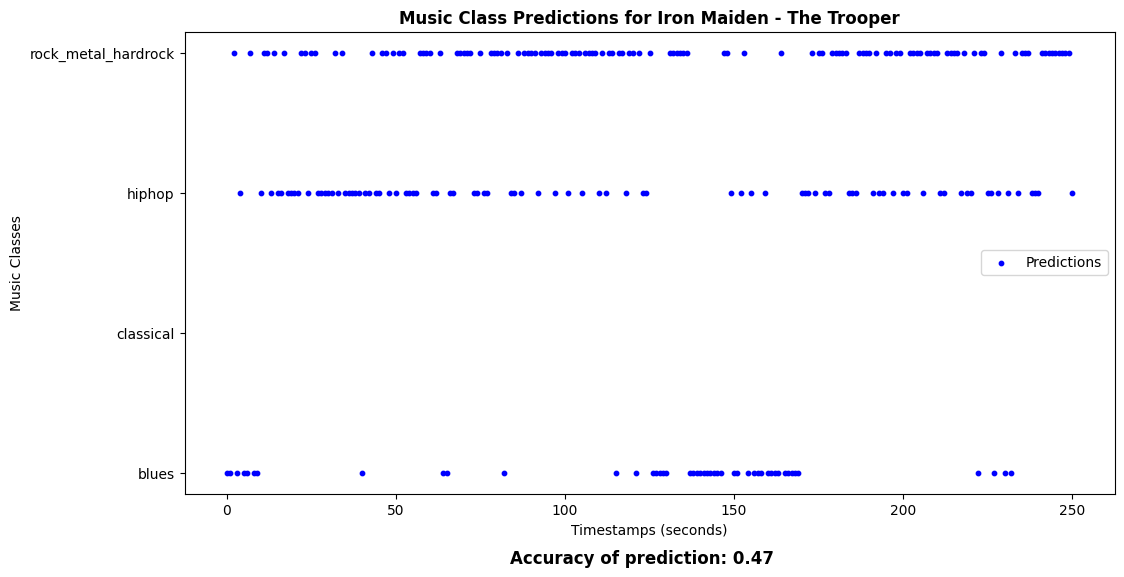

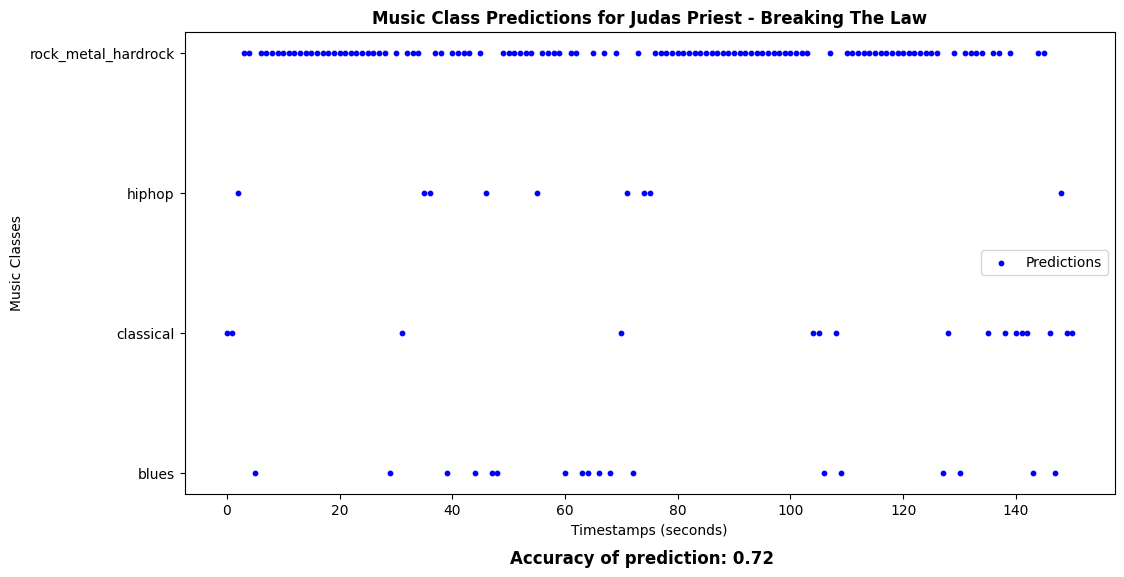

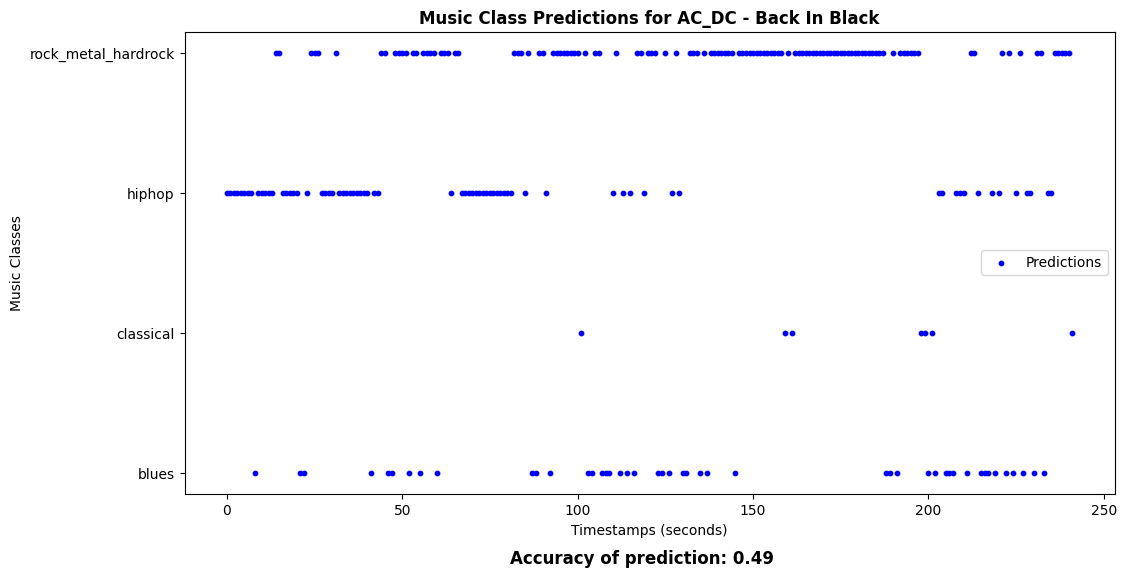

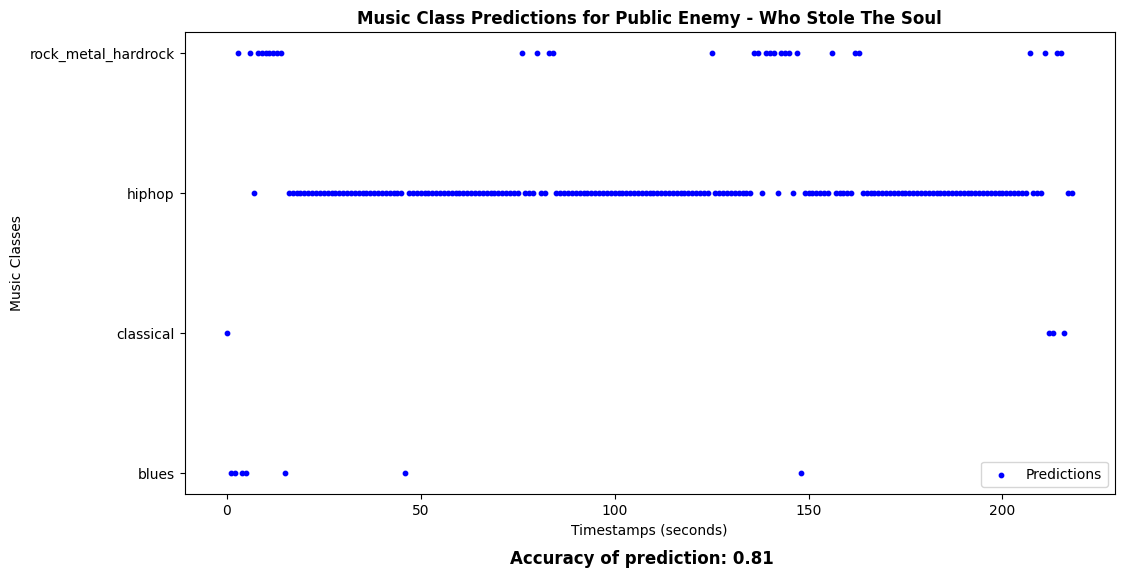

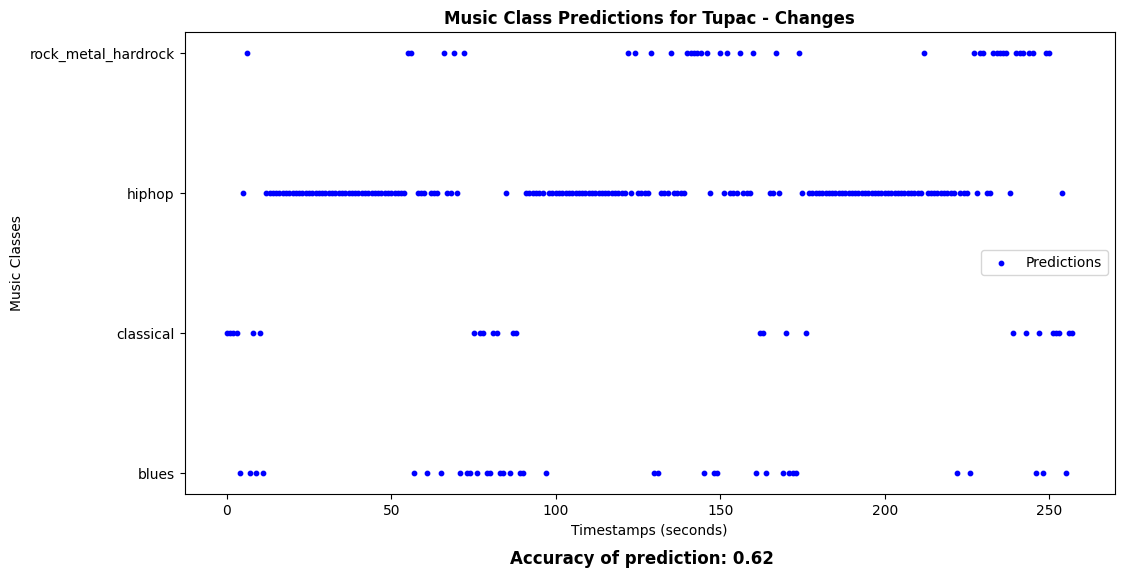

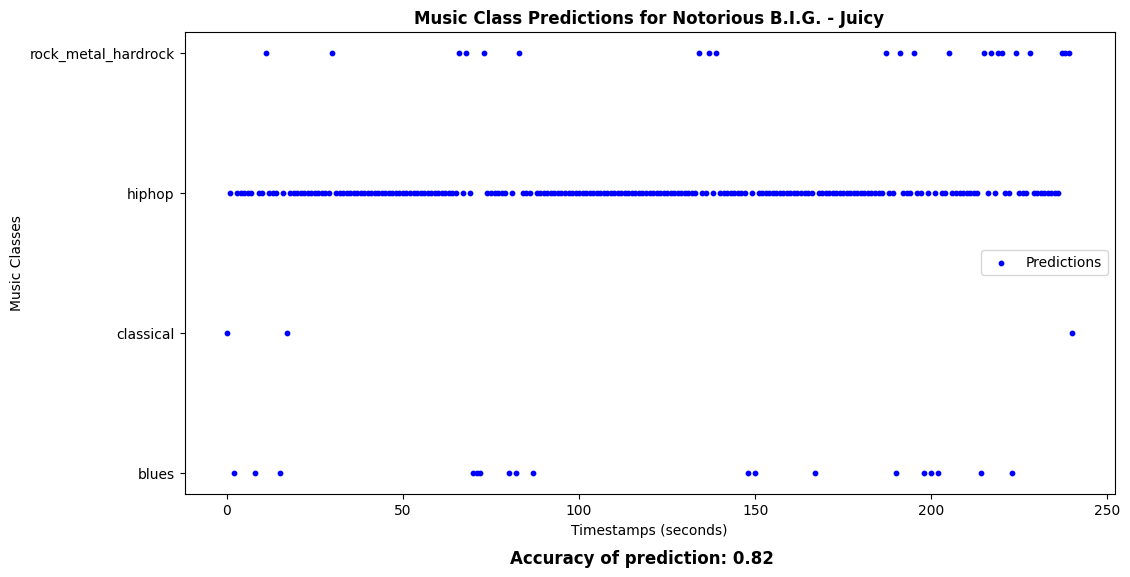

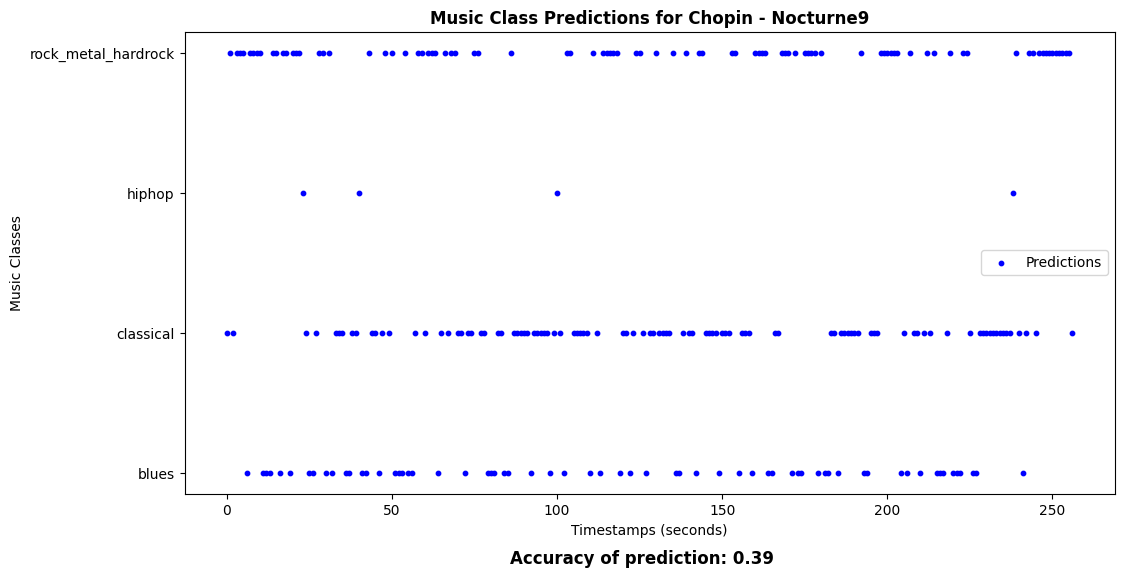

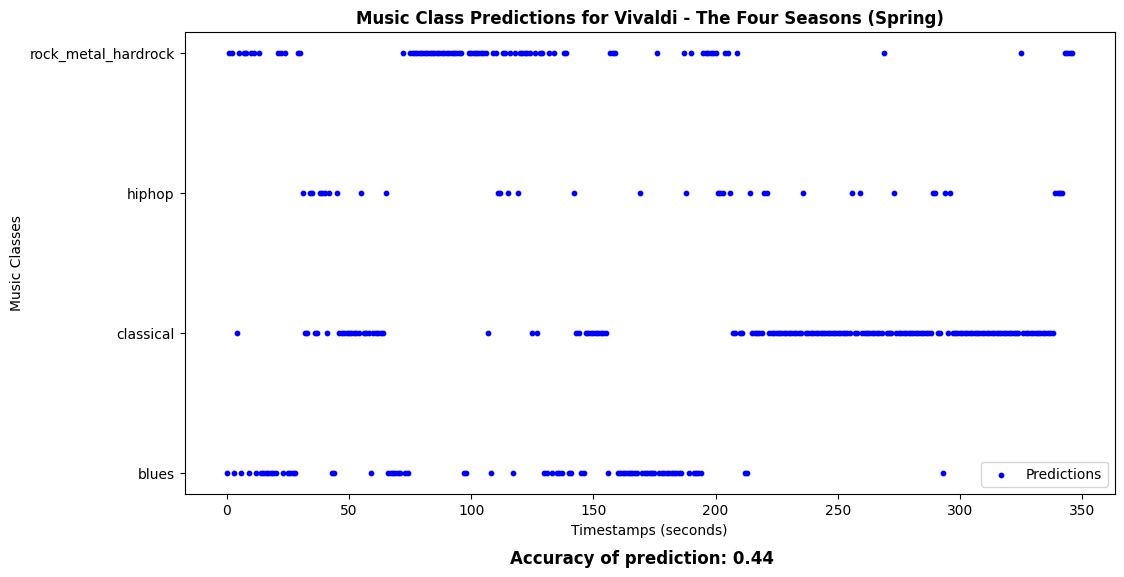

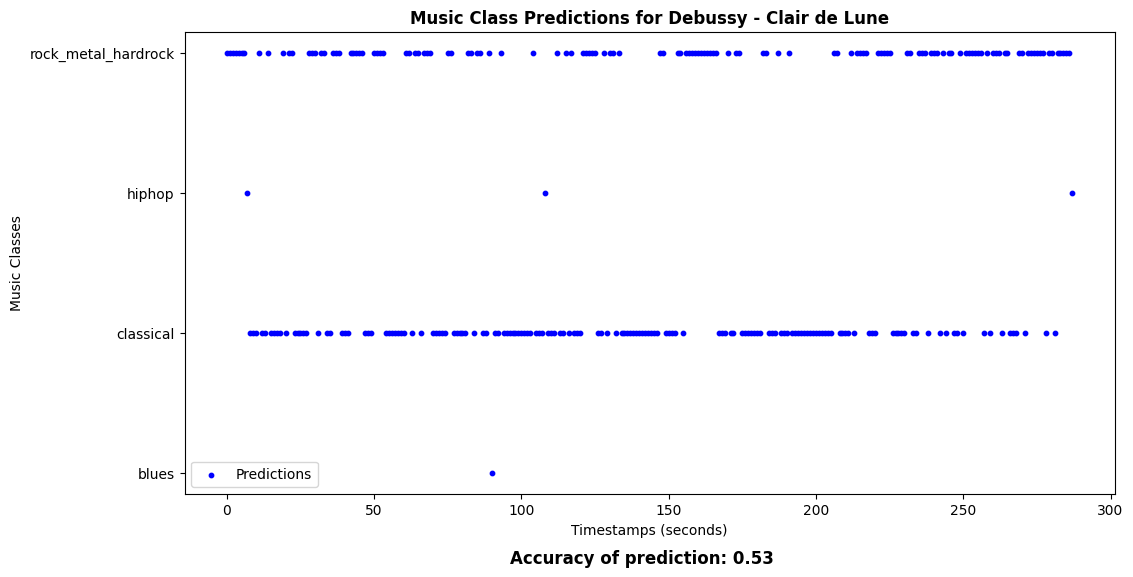

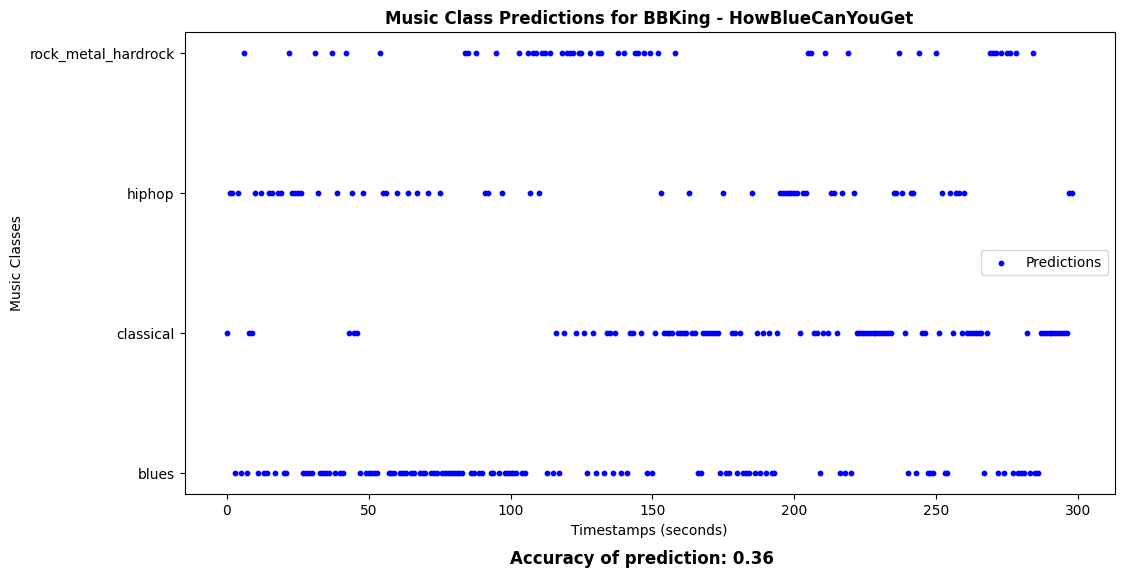

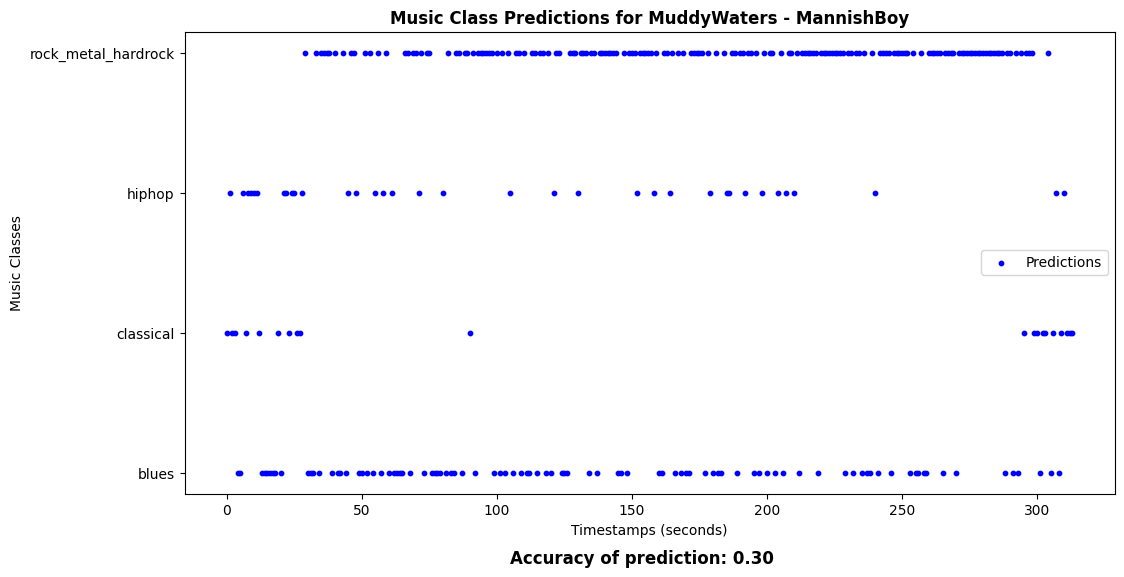

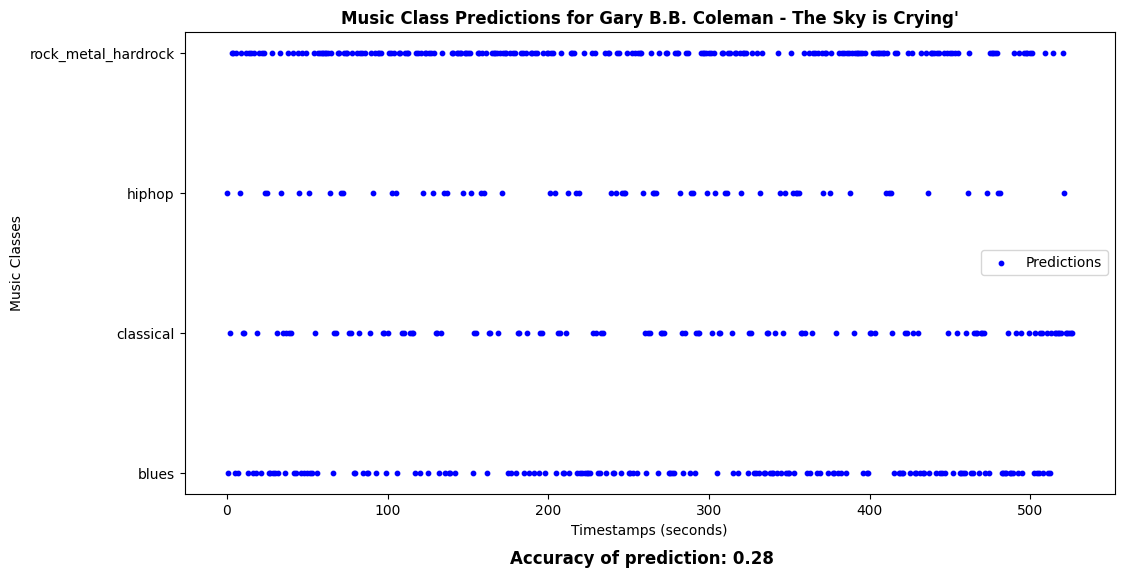

In [18]:
rock_metalURLs = {
    "Iron Maiden - The Trooper": "https://www.youtube.com/watch?v=X4bgXH3sJ2Q",
    "Judas Priest - Breaking The Law": "https://www.youtube.com/watch?v=L397TWLwrUU",
    "AC_DC - Back In Black": "https://www.youtube.com/watch?v=pAgnJDJN4VA"
}

hiphopURLs = {
    "Public Enemy - Who Stole The Soul": "https://www.youtube.com/watch?v=ty4vKAQdOz0",
    "Tupac - Changes": "https://www.youtube.com/watch?v=eXvBjCO19QY",
    "Notorious B.I.G. - Juicy": "https://www.youtube.com/watch?v=_JZom_gVfuw"
}

classicURLs = {
    "Chopin - Nocturne9": "https://www.youtube.com/watch?v=9E6b3swbnWg",
    "Vivaldi - The Four Seasons (Spring)": "https://www.youtube.com/watch?v=6LAPFM3dgag",
    "Debussy - Clair de Lune": "https://www.youtube.com/watch?v=CvFH_6DNRCY"
}

bluesURLs = {
    "BBKing - HowBlueCanYouGet": "https://www.youtube.com/watch?v=l45f28PzfCI",
    "MuddyWaters - MannishBoy": "https://www.youtube.com/watch?v=bSfqNEvykv0",
    "Gary B.B. Coleman - The Sky is Crying'": "https://www.youtube.com/watch?v=71Gt46aX9Z4"
}


for songtitle, url in rock_metalURLs.items():
    predict_genre(url, songtitle, 'rock_metal_hardrock', cnn_mel_model)

for songtitle, url in hiphopURLs.items():
    predict_genre(url, songtitle, 'hiphop', cnn_mel_model)

for songtitle, url in classicURLs.items():
    predict_genre(url, songtitle, 'classical', cnn_mel_model)

for songtitle, url in bluesURLs.items():
    predict_genre(url, songtitle, 'blues', cnn_mel_model)


### Final Conclusion

The model reached a theoretical F1 Score of 0.7689 and an accuracy of 0.7653 on the test set. In real-world testing, the classifier performed well on Hip-Hop but showed inconsistency with Blues and Classical music. These results indicate that while the CNN architecture is effective for rhythmic genres, its performance on acoustic or complex tracks is limited by the diversity of the training data. Future improvements would require expanding the dataset to cover a wider range of musical styles.

<center>-----</center>